
# Model of "ISAAC: A Convolutional Neural Network Accelerator with In-Situ
Analog Arithmetic in Crossbars!", ISAC 2016
--------------------------------------------------------------------------------

Paper by Ali Shafiee, Anirban Nag, Naveen Muralimanohar, Rajeev Balasubramonian,
John Paul Strachan, Miao Hu, R. Stanley Williams, and Vivek Srikumar.

ISAAC is a ReRAM-based analog CiM accelerator. It explores several concepts in
CiM acceleration, including storing different layers in different arrays and
pipelining inputs/outputs between.

Some of the important variables for isaac_isca_2016:

- *ARRAY_WORDLINES*: 128 rows in the array
- *ARRAY_BITLINES*: 128 columns in the array
- *ARRAY_PARALLEL_INPUTS*: 128 input slice(s) consumed in each cycle.
- *ARRAY_PARALLEL_WEIGHTS*: 16384 weights slice(s) used for computation in each cycle.
- *ARRAY_PARALLEL_OUTPUTS*: 128 output(s) produced in each cycle.
- *TECHNOLOGY*: 32 nm
- *ADC_RESOLUTION*: 8 bit(s)
- *DAC_RESOLUTION*: 1 bit(s)
- *N_ADC_PER_BANK*: 1 ADC(s)
- *SUPPORTED_INPUT_BITS*: 8 bit(s)
- *SUPPORTED_OUTPUT_BITS*: 8 bit(s)
- *SUPPORTED_WEIGHT_BITS*: 8 bit(s)
- *BITS_PER_CELL*: 2 bit(s)
- *CIM_UNIT_WIDTH_CELLS*: 1 adjacent cell(s) in a wordline store bit(s) in one weight slice and process one input & output slice together
- *CIM_UNIT_DEPTH_CELLS*: 1 adjacent cell(s) in a bitline operate in separate cycles
- *CELL_CONFIG*: /home/tanner/research/cimloop/cimloop/workspace/models/memory_cells/rram_isaac_isca_2016.cell.yaml 
- *GLOBAL_CYCLE_SECONDS*: 1e-09 clock period

### Tile Level

Twelve macros (called IMAs in the paper) are organized into a tile. Each tile
includes a 64kB eDRAM buffer storing 16b inputs/outputs and quantization
circuits. The original paper included sigmoid units at this level, but we
replaced them with quantization circuits to match the other works. ISAAC uses
16b fixed-point quantization for all operands.

- *Input Path*: Inputs are stored in the eDRAM. An inter-macro network sends
  inputs to macros in the tile.
- *Weight Path*: Weights are kept static in inference and do not move through
  this level.
- *Output Path*: Outputs are gathered from macros via the inter-tile network.
  They are quantized before being stored in the eDRAM.

Next, there are 12 macros in each tile. Inputs and outputs are unicast between
macros.

### Macro Level

Eight arrays are organized into a macro with an input register and output
register. An input network sends input vectors to arrays.

The eight arrays can process up to 8×128 = 1024 inputs across all rows, so the
input register is sized 2kB (2B per input). The output register is sized 256B
(2B per output, 128 outputs total (8 arrays × 128 columns × 2b per column / 16b
per output)). While the paper does not do this, we double output buffer size to
account for higher-precision accumulation that is important for lower-precision
quantization.

- *Input Path*: Inputs are stored in the input buffer and multicast between
  arrays.
- *Weight Path*: Weights are kept static in inference and do not move through
  this level.
- *Output Path*: Outputs are stored in the output buffer and spatially reduced
  between arrays. Before the output buffer, a shift+add circuit accumulates
  outputs and corrects for offsets caused by slicing.

Next, there are 8 arrays in each macro. Inputs and outputs can be spatially
reused across arrays with a multicast/reduction network.

### Array Level

Arrays consist of 128 × 128 2T2Rs. Each array is programmed with weights from
one DNN layer, and each weight filter uses 8 array columns (16b weights, 2b per
column). 1-bit DACs encode inputs across 16 cycles and 8-bit ADCs convert
outputs from each column.

We note that the original ISAAC paper included a contribution to decrease
required ADC precision. Instead of supporting between 0 and the maximum output
of a column, ISAAC supported only half of the range. They ensured that all
column outputs would be in this range at program time. If the average weight
slice value in a column was less than half of the maximum output, the column
could not saturate the ADC. If the average weight slice value was greater than
half of the maximum output, ISAAC would store the negated value of the weights.
To correct for this, ISAAC would need to record sums of the input values, record
which weight columns were negated, and perform arithmetic to recover the real
sums from the negated sums.

When we modeled ISAAC's accuracy, we found that this technique was not helpful
across any tested workloads because weights tended to have about half of the
maximum value and input bits tended to have >50% sparsity, so on average output
of a column was around 25% of the output range anyway and never exceeded 50%. We
can therefore just use the lower half of the ADC range to achieve the same
result (lower ADC precision) without any of the additional complexity introduced
by this strategy. For this reason, we don't model this technique in our ISAAC
model.

Inputs and weights are both assumed to be 16b unsigned fixed-point numbers.
Signed inputs and weights are converted by adding a bias to the inputs and
weights.

- *Input Path*: Inputs pass through a 1-bit DACs and appear on the rows of the
  array.
- *Weight Path*: Weights are stored in the array and are not moved during
  inference.
- *Output Path*: Outputs are read from the columns of the array with 8-bit ADCs.

Next, there are 128 columns in each array. Inputs are reused between columns
(*i.e.,* each input-carrying wire connects to all columns), while outputs and
weights are not reused.

### Column Level

Each column consists of 128 ReRAM devices. Columns store 2b weight slices.

- *Input Path*: Each input is passed directly to a row in the column.
- *Weight Path*: Weights are not moved during inference.
- *Output Path*: Outputs pass through a current mirror to buffer their values
  before exiting the column.
  
### Row Level

Each row in a column has one ReRAM device which stores an offset-encoded 2b
weight slice.

- *Input Path*: The input is used for a MAC operation.
- *Weight Path*: A 2b weight is stored in the ReRAM device and is used for a MAC
  operation.
- *Output Path*: The output is supplied by a MAC operation.

                 


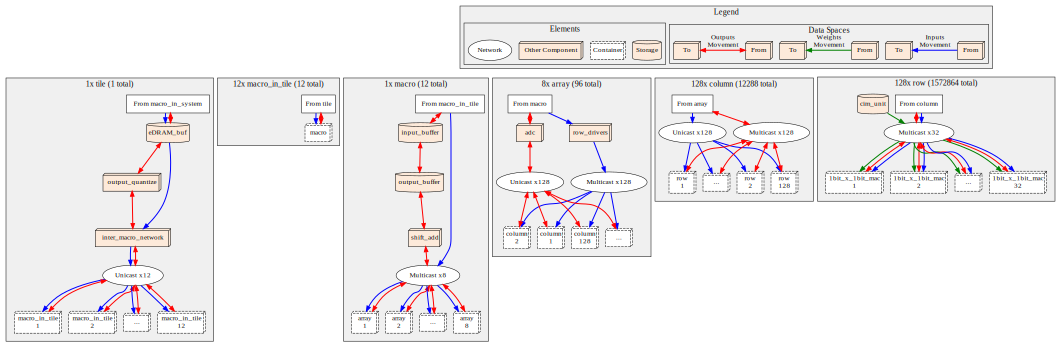

In [ ]:
from _tests import scripts
from scripts.notebook_utils import *

display_markdown(f"""
# Model of "ISAAC: A Convolutional Neural Network Accelerator with In-Situ
Analog Arithmetic in Crossbars!", ISAC 2016
--------------------------------------------------------------------------------

Paper by Ali Shafiee, Anirban Nag, Naveen Muralimanohar, Rajeev Balasubramonian,
John Paul Strachan, Miao Hu, R. Stanley Williams, and Vivek Srikumar.

ISAAC is a ReRAM-based analog CiM accelerator. It explores several concepts in
CiM acceleration, including storing different layers in different arrays and
pipelining inputs/outputs between.

{get_important_variables_markdown('isaac_isca_2016')}

### Tile Level

Twelve macros (called IMAs in the paper) are organized into a tile. Each tile
includes a 64kB eDRAM buffer storing 16b inputs/outputs and quantization
circuits. The original paper included sigmoid units at this level, but we
replaced them with quantization circuits to match the other works. ISAAC uses
16b fixed-point quantization for all operands.

- *Input Path*: Inputs are stored in the eDRAM. An inter-macro network sends
  inputs to macros in the tile.
- *Weight Path*: Weights are kept static in inference and do not move through
  this level.
- *Output Path*: Outputs are gathered from macros via the inter-tile network.
  They are quantized before being stored in the eDRAM.

Next, there are 12 macros in each tile. Inputs and outputs are unicast between
macros.

### Macro Level

Eight arrays are organized into a macro with an input register and output
register. An input network sends input vectors to arrays.

The eight arrays can process up to 8×128 = 1024 inputs across all rows, so the
input register is sized 2kB (2B per input). The output register is sized 256B
(2B per output, 128 outputs total (8 arrays × 128 columns × 2b per column / 16b
per output)). While the paper does not do this, we double output buffer size to
account for higher-precision accumulation that is important for lower-precision
quantization.

- *Input Path*: Inputs are stored in the input buffer and multicast between
  arrays.
- *Weight Path*: Weights are kept static in inference and do not move through
  this level.
- *Output Path*: Outputs are stored in the output buffer and spatially reduced
  between arrays. Before the output buffer, a shift+add circuit accumulates
  outputs and corrects for offsets caused by slicing.

Next, there are 8 arrays in each macro. Inputs and outputs can be spatially
reused across arrays with a multicast/reduction network.

### Array Level

Arrays consist of 128 × 128 ReRAMs. Each array is programmed with weights from
one DNN layer, and each weight filter uses 8 array columns (16b weights, 2b per
column). 1-bit DACs encode inputs across 16 cycles and 8-bit ADCs convert
outputs from each column.

We note that the original ISAAC paper included a contribution to decrease
required ADC precision. Instead of supporting between 0 and the maximum output
of a column, ISAAC supported only half of the range. They ensured that all
column outputs would be in this range at program time. If the average weight
slice value in a column was less than half of the maximum output, the column
could not saturate the ADC. If the average weight slice value was greater than
half of the maximum output, ISAAC would store the negated value of the weights.
To correct for this, ISAAC would need to record sums of the input values, record
which weight columns were negated, and perform arithmetic to recover the real
sums from the negated sums.

When we modeled ISAAC's accuracy, we found that this technique was not helpful
across any tested workloads because weights tended to have about half of the
maximum value and input bits tended to have >50% sparsity, so on average output
of a column was around 25% of the output range anyway and never exceeded 50%. We
can therefore just use the lower half of the ADC range to achieve the same
result (lower ADC precision) without any of the additional complexity introduced
by this strategy. For this reason, we don't model this technique in our ISAAC
model.

Inputs and weights are both assumed to be 16b unsigned fixed-point numbers.
Signed inputs and weights are converted by adding a bias to the inputs and
weights.

- *Input Path*: Inputs pass through a 1-bit DACs and appear on the rows of the
  array.
- *Weight Path*: Weights are stored in the array and are not moved during
  inference.
- *Output Path*: Outputs are read from the columns of the array with 8-bit ADCs.

Next, there are 128 columns in each array. Inputs are reused between columns
(*i.e.,* each input-carrying wire connects to all columns), while outputs and
weights are not reused.

### Column Level

Each column consists of 128 ReRAM devices. Columns store 2b weight slices.

- *Input Path*: Each input is passed directly to a row in the column.
- *Weight Path*: Weights are not moved during inference.
- *Output Path*: Outputs pass through a current mirror to buffer their values
  before exiting the column.
  
### Row Level

Each row in a column has one ReRAM device which stores an offset-encoded 2b
weight slice.

- *Input Path*: The input is used for a MAC operation.
- *Weight Path*: A 2b weight is stored in the ReRAM device and is used for a MAC
  operation.
- *Output Path*: The output is supplied by a MAC operation.

                 
""")
display_diagram(get_diagram("isaac_isca_2016", ignore=DIAGRAM_DEFAULT_IGNORE, tile="isaac"))


   This test explores the energy, area, and latency of the accelerator
   computing MVM operations. We note a few differences from the original ISAAC
   paper. Notably, we made a few changes to the quantization, and we use
   data-value-dependent models while ISAAC used a simple fixed-power model.
   
   We note:
   - Energy is dominated by the ADC and memory cells due to the high ADC precision
     and large number of slices.
   - Area is dominated by ADC.
   

100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


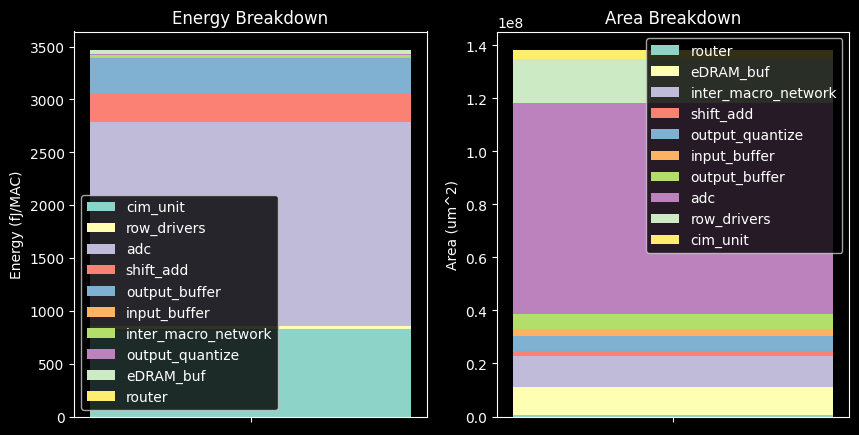

In [2]:
result = run_test("isaac_isca_2016", "test_energy_breakdown")
n_subplots = len(result)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
bar_stacked(
    {f"": r.per_compute('per_component_energy')*1e15 for r in result},
    ylabel="Energy (fJ/MAC)",
    title=f"Energy Breakdown",
    ax=axs[0]
)
bar_stacked(
    {f"" : r.per_component_area*1e12 for r in result},
    ylabel="Area (um^2)",
    title=f"Area Breakdown",
    ax=axs[1]
)


In [ ]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
results = {}
for i, dnn in enumerate(["resnet18", "mobilenet_v3", "gpt2_medium"]):
    results[dnn] = run_test(
        "isaac_isca_2016", "test_full_dnn", dnn_name=dnn, show_doc=i == 0
    )

# Full-DNN results
fig, axs = plt.subplots(1, 4, figsize=(20, 5))


consolidated = {f'{dnn}': result.aggregate() for dnn, result in results.items() }
bar_stacked( # Per-MAC Energy
    {k: r.per_compute('per_component_energy')*1e15 for k, r in consolidated.items()},
    xlabel="DNN",
    ylabel="Energy (fJ/MAC)",
    title="Per-MAC Energy",
    ax=axs[0],
)
bar_stacked( # Total Energy
    {k: r.per_component_energy*1e3 for k, r in consolidated.items()},
    xlabel="DNN",
    ylabel="Energy (mJ)",
    title="Total Energy",
    ax=axs[1],
)

tops, tops_per_w = {}, {}
for dnn, r in results.items():
    agg = r.aggregate()
    tops[dnn] = {"": agg.tops}
    tops_per_w[dnn] = {"": agg.tops_per_w}

for ax, data, title, ylabel in [
    (axs[2], tops, "Throughput", "TOPS"),
    (axs[3], tops_per_w, "Energy Efficiency", "TOPS/W"),
]:
    bar_side_by_side(
        tops,
        xlabel="DNN",
        ylabel=f"{title} ({ylabel})",
        title=f"Full-DNN {title}",
        ax=ax,
    )

# Per-Layer Results
for dnn, result in results.items():
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    bar_stacked(
        {i: r.per_compute('per_component_energy')*1e15 for i, r in enumerate(result)},
        xlabel="Layer",
        ylabel="Energy (fJ/MAC)",
        title=f"{dnn} Per-Layer Energy",
        ax=ax[0],
    )
    for ax, attrname, title, ylabel, scaleby in [
        (ax[1], "latency", "Latency", "us", 1e6),
        (ax[2], "energy", "Total Energy", "mJ", 1e9),
    ]:
        bar_side_by_side(
            {i: {"": getattr(r, attrname) * scaleby} for i, r in enumerate(result)},
            xlabel="Layer",
            ylabel=f"{title} ({ylabel})",
            title=f"{dnn} Per-Layer {title}",
            ax=ax,
        )
        


   This test explores the energy, area, and latency of the accelerator when
   running full DNN workloads.
   

  0%|          | 0/64 [00:00<?, ?it/s]